# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

print("num gpu avalidble: ", len(tf.config.list_physical_devices('GPU')))

num gpu avalidble:  0


In [2]:
import pathlib
#setting up data.
data_directory = pathlib.Path("Intel_Image_Classification")

# Verify the directory exists
if not data_directory.exists():
    raise Exception("Directory not found! Please check the path.")

train_directory =pathlib.Path("Intel_Image_Classification/seg_train/seg_train")
print(train_directory)

test_directory =pathlib.Path("Intel_Image_Classification/seg_test/seg_test")

image_count = len(list(train_directory.glob('*/*.jpg')))
print(image_count)



Intel_Image_Classification\seg_train\seg_train
14034


In [3]:
#Creating the dataset

batch_size = 32
img_height = 150
img_width = 150

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_dataset.class_names
print(class_names)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


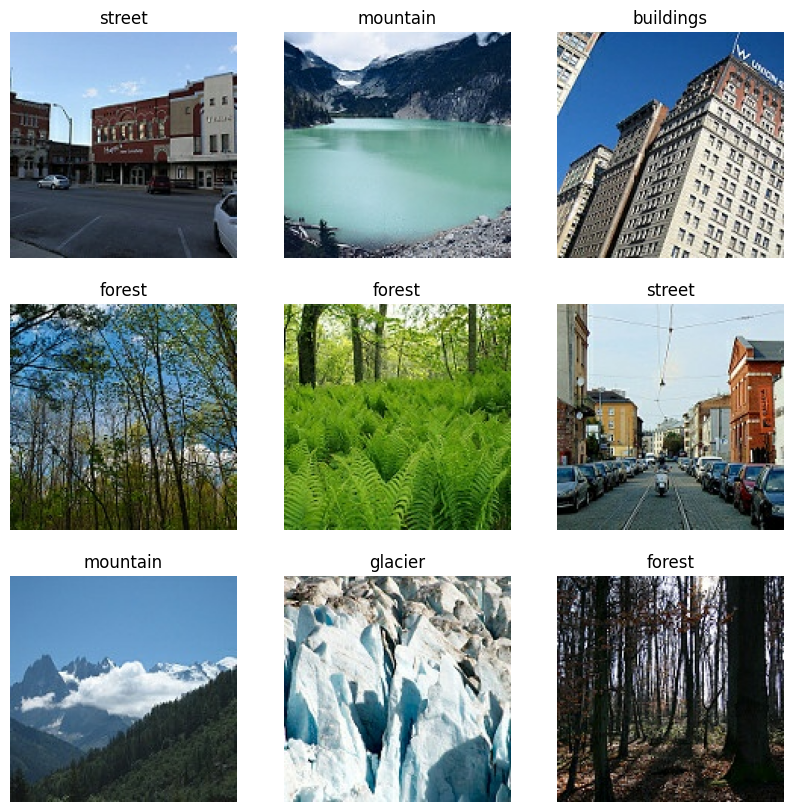

In [4]:
#visualize Data test:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE #tensorflow will auto determine optimal values

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
#Standardize Data. This will limit pixel values to be 0 to 1 instead of 0 to 255
normalization_layer = layers.Rescaling(1./255)

#apply layer to the datasset
normalize_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalize_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) #becomes 0.0 1.0

0.0 1.0


In [7]:
#Mode optimization:

# data augmentation. Generates additional training data, using random transformers (like rotating, zooming, and flipping the images to make 'new' training data)
data_augment = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#early stoppping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

C:\Users\Infer\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
#Creating image model


num_classes = len(class_names) #number of classes for the image sets

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'), #convolution layer
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'), #dense layers
    layers.Dense(num_classes)
])

In [9]:
#use standard adam optimizer
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #good loss function?
              metrics=['accuracy'])
model.summary() #check if model is good.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,694 (10.22 MB)

 Trainable params: 2,678,694 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs= 10 #train model
model_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    #callbacks=[early_stopping]
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.5435 - loss: 1.1817 - val_accuracy: 0.7253 - val_loss: 0.7324
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.7577 - loss: 0.6718 - val_accuracy: 0.7437 - val_loss: 0.6970
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8197 - loss: 0.5065 - val_accuracy: 0.7930 - val_loss: 0.5834
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8631 - loss: 0.3799 - val_accuracy: 0.8133 - val_loss: 0.5395
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9014 - loss: 0.2787 - val_accuracy: 0.8080 - val_loss: 0.6047
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9281 - loss: 0.1953 - val_accuracy: 0.8153 - val_loss: 0.6245
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9505 - loss: 0.1452 - val_accuracy: 0.8167 - val_loss: 0.6547
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9572 - loss: 0.1221 - 

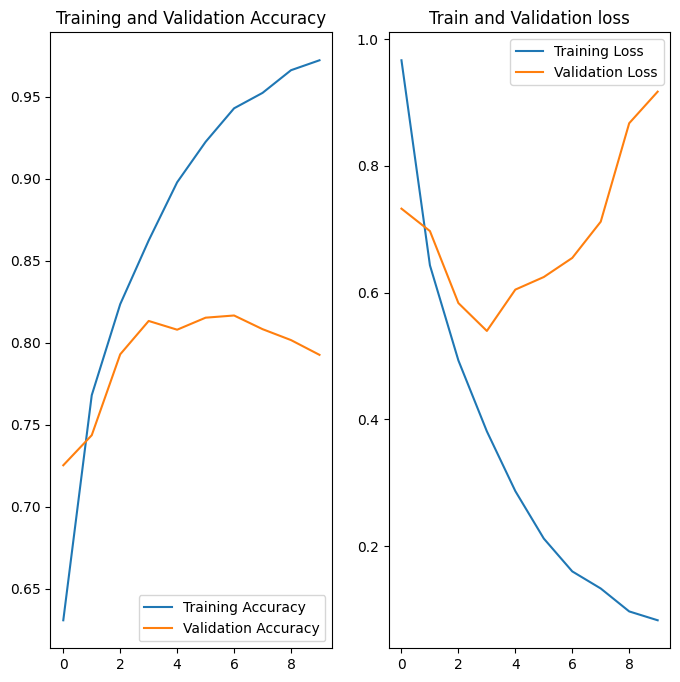

In [12]:
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs_range = range(epochs)

#mat plot lib it
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation loss')
plt.show()
